In [1]:
import sys, os, glob, datetime, cftime,pickle
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
from scipy import float64
from dill.source import getsource
import regionmask

sys.path.append('../')

from _decomp import *
from _data_minimal import *
from _print_and_plot import *

%load_ext autoreload 
%autoreload 2

In [2]:
target_variable='TREFHT'
cov_variable = 'stream'
months=[6,7,8]
months_str = ','.join([str(m) for m in months])
tag = f"ERA5_{target_variable}_{'m'.join([str(m) for m in months])}_{cov_variable}"

In [3]:
period = [1979,2023]
y1,y2 = period

In [4]:
trend_dict = {}

In [5]:
oo = decomp_ERA5(target_variable=target_variable, months=months, period=period)
oo.target_open(0, 360, 30, 70, var_name_in_file='var167', cdo_options='-remapcon,r360x180')
tas = oo._data_raw['target']
tas = tas.assign_coords(lon=(tas.lon + 180) % 360 - 180)
tas = tas.assign_coords(lat=tas.lat.round(3))
tas = tas.groupby(tas.time.dt.year).mean()
tas = tas.loc[:,:60]
trend_dict[f"raw_{y1}-{y2}"] = tas.polyfit('year', deg=1)['polyfit_coefficients'][0].squeeze()

In [6]:
out_path = '/climca/people/ppfleiderer/decomposition/decomp_out'
y1,y2 = period
cc = decomp_ERA5(target_variable=target_variable, months=months, period=period)
cc.target_open(0, 360, 30, 70, var_name_in_file='var167', cdo_options='-remapcon,r360x180')
for component in ['circ','thermo']:
    tab = pd.read_csv(f'{out_path}/{tag}_{y1}-{y2}/ERA5_trend_predict_{component}.csv', index_col=0)
    tab = tab.iloc[np.isfinite(tab.index)]
    tab.index = [int(i) for i in tab.index]
    y = cc._data_raw['target'].copy()[0].squeeze() * np.nan
    y = y.assign_coords(lat = y.lat.round(1))
    y = y.assign_coords(lon = y.lon.round(1))
    for i in range(tab.shape[0]):
        try:
            y.loc[round(tab.iloc[i,0],1),round(tab.iloc[i,1],1)] = tab.iloc[i,2]
        except:
            pass
    y = y.loc[:60]
    y = y.assign_coords(lon=(y.lon + 180) % 360 - 180)
    trend_dict[f"ridge_{component}_{y1}-{y2}"] = y

In [7]:
data_path = '/climca/data/ETH2LIM/ETH2LIM/for_sebastian'
y1,y2 = period
reg = 'NH'

analog_in_file = f"/climca/data/ETH2LIM/ETH2LIM/for_sebastian/tasAdj_mon_ERA5_{reg}.nc"
nc = xr.open_dataset(analog_in_file)
nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
x = nc['tas_dyn']
x = x[np.isin(x.time.dt.month, months)]
x = x.loc[str(period[0]):str(period[1])]
x = x.groupby(x.time.dt.year).mean()
trend = x.polyfit('year', deg=1)['polyfit_coefficients'][0].squeeze()
trend_dict[f'analog_circ_{y1}-{y2}'] = trend

trend_dict[f'analog_thermo_{y1}-{y2}'] = trend_dict[f'raw_{y1}-{y2}'] - trend_dict[f'analog_circ_{y1}-{y2}']

In [8]:
for component in ['circ','thermo']:
    y = xr.load_dataarray(f'/climca/people/ppfleiderer/decomposition/DEA_homer/ERA5_trend_{y1}-{y2}_{component}.nc')
    y = y.loc[:60]
    y = y.assign_coords(lon=(y.lon + 180) % 360 - 180)
    trend_dict[f"DEA_{component}_{y1}-{y2}"] = y

In [9]:
with xr.open_dataarray('/climca/data/ETH2LIM/CNRM2LIM/UNET_ERA5/UNET_ERA5_1979_2023.nc') as tas:
    tas = tas.assign_coords(lon=(tas.lon + 180) % 360 - 180)
    tas = tas.assign_coords(lat=tas.lat.round(3))
    tas = tas[np.isin(tas.time.dt.month, months)]
    tas = tas.groupby(tas.time.dt.year).mean()
    trend_circ = tas.polyfit('year', deg=1)['polyfit_coefficients'][0].squeeze()
    regridder = xe.Regridder(trend_circ, trend_dict[f'raw_{y1}-{y2}'], method='bilinear')
    trend_dict[f'UNET_circ_{y1}-{y2}'] = regridder(trend_circ)
    trend_dict[f'UNET_thermo_{y1}-{y2}'] = trend_dict[f'raw_{y1}-{y2}'] - trend_dict[f'UNET_circ_{y1}-{y2}']

In [10]:
for name,y in trend_dict.items():
    mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(y.lon, y.lat)
    mask.values[np.isfinite(mask)] = 1
    trend_dict[name] = y * mask

In [11]:
maxabs = 0.6
extent = [-180, 180, 30, 60]
levels = np.linspace(-maxabs,maxabs,31)

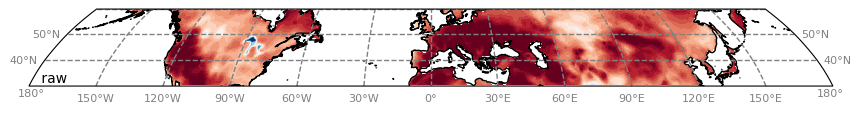

In [12]:
y = trend_dict[f"raw_{y1}-{y2}"]    
y = y.loc[30:60].roll(lon=int(0.5*y.shape[1]), roll_coords=True)
fig,ax = plt.subplots(nrows=1, figsize=(12,1), subplot_kw={'projection': cartopy.crs.Robinson()})
ax.set_extent(extent, crs=cartopy.crs.PlateCarree())
ax.coastlines()
im = ax.contourf(y.lon, y.lat, y * 10, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
ax.set_facecolor('w')
ax.annotate(f" raw", xy=(0.01,0.05), xycoords='axes fraction', fontsize=10)

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=1, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,200,30,'int'))
gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(40,61,10,'int'))
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}

savefig(f"ERA5_trend_map_raw_{y1}-{y2}")

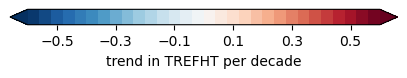

In [13]:
fig,ax = plt.subplots(figsize=(5, 0.2))
plt.colorbar(im, cax=ax, orientation='horizontal', label=f'trend in {target_variable} per decade', ticks=[-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
savefig(f"trend_maps_cbar_{maxabs}")

In [16]:
to_plot = {
    'ridge' : 'ridge',
    'analog' : 'analogues',
    'DEA' : 'DEA',
    'UNET' : 'UNET',
}

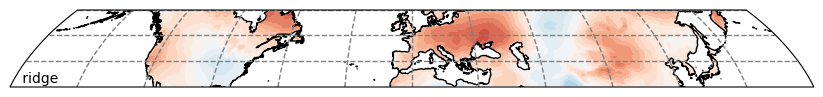

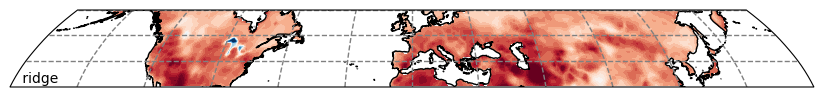

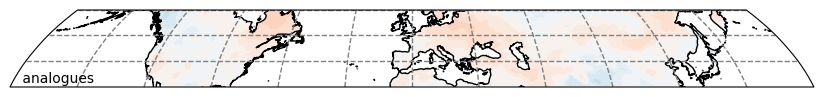

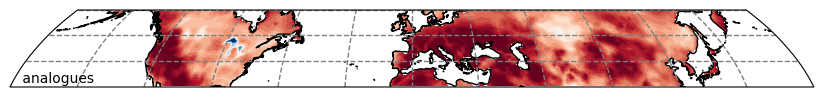

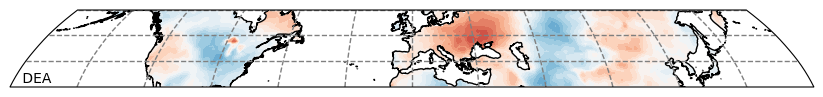

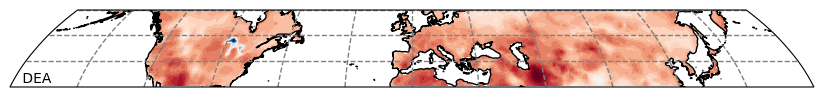

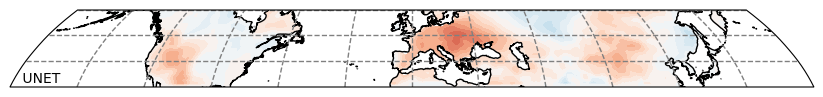

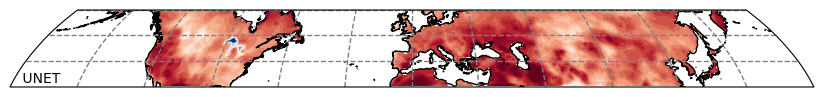

In [17]:

for name,long_name in to_plot.items():
    for component in ['circ','thermo']:
        y = trend_dict[f"{name}_{component}_{y1}-{y2}"]    
        y = y.loc[30:60].roll(lon=int(0.5*y.shape[1]), roll_coords=True)
        fig,ax = plt.subplots(nrows=1, figsize=(12,1), subplot_kw={'projection': cartopy.crs.Robinson()})
        ax.set_extent(extent, crs=cartopy.crs.PlateCarree())
        ax.coastlines()
        im = ax.contourf(y.lon, y.lat, y * 10, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
c

        savefig(f"ERA5_trend_map_{name}_{component}_{y1}-{y2}")